In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
sns.set_theme(context='notebook', style='whitegrid', palette='muted')

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [4]:
data_dir = Path('../../results')
train = pd.read_csv(data_dir / 'train_clean.csv')

In [5]:
num_cols = train.dtypes[(train.dtypes == 'float64') | (train.dtypes == 'int64')].index
num_cols

Index(['startYear', 'runtimeMinutes', 'numVotes', 'totalImages',
       'totalCredits', 'numRegions', 'companiesNumber', 'averageRating',
       'externalLinks', 'writerCredits', 'numGenres', 'criticReviewsRatio'],
      dtype='object')

In [6]:
scaler = RobustScaler()
train_X = scaler.fit_transform(train[num_cols])

## HBOS

In [7]:
from pyod.models.hbos import HBOS

In [8]:
def sturges_law(N):
    return 1 + math.log(N, 2)

sturges_law(train_X.shape[0])

17.675405775802762

In [9]:
detector = HBOS(n_bins='auto', contamination=0.01)

In [10]:
detector.fit(train_X)

HBOS(alpha=0.1, contamination=0.01, n_bins='auto', tol=0.5)

In [11]:
outliers = detector.predict(train_X)

In [12]:
threshold = detector.decision_scores_[np.where(outliers == 1)].min()

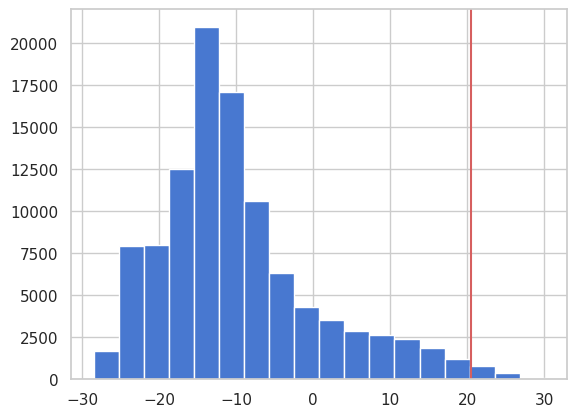

In [13]:
plt.hist(detector.decision_scores_, bins=18)
plt.axvline(threshold, c='r')
plt.show()

### Analysis of candidate outliers

In [14]:
train['hbos'] = outliers == 1

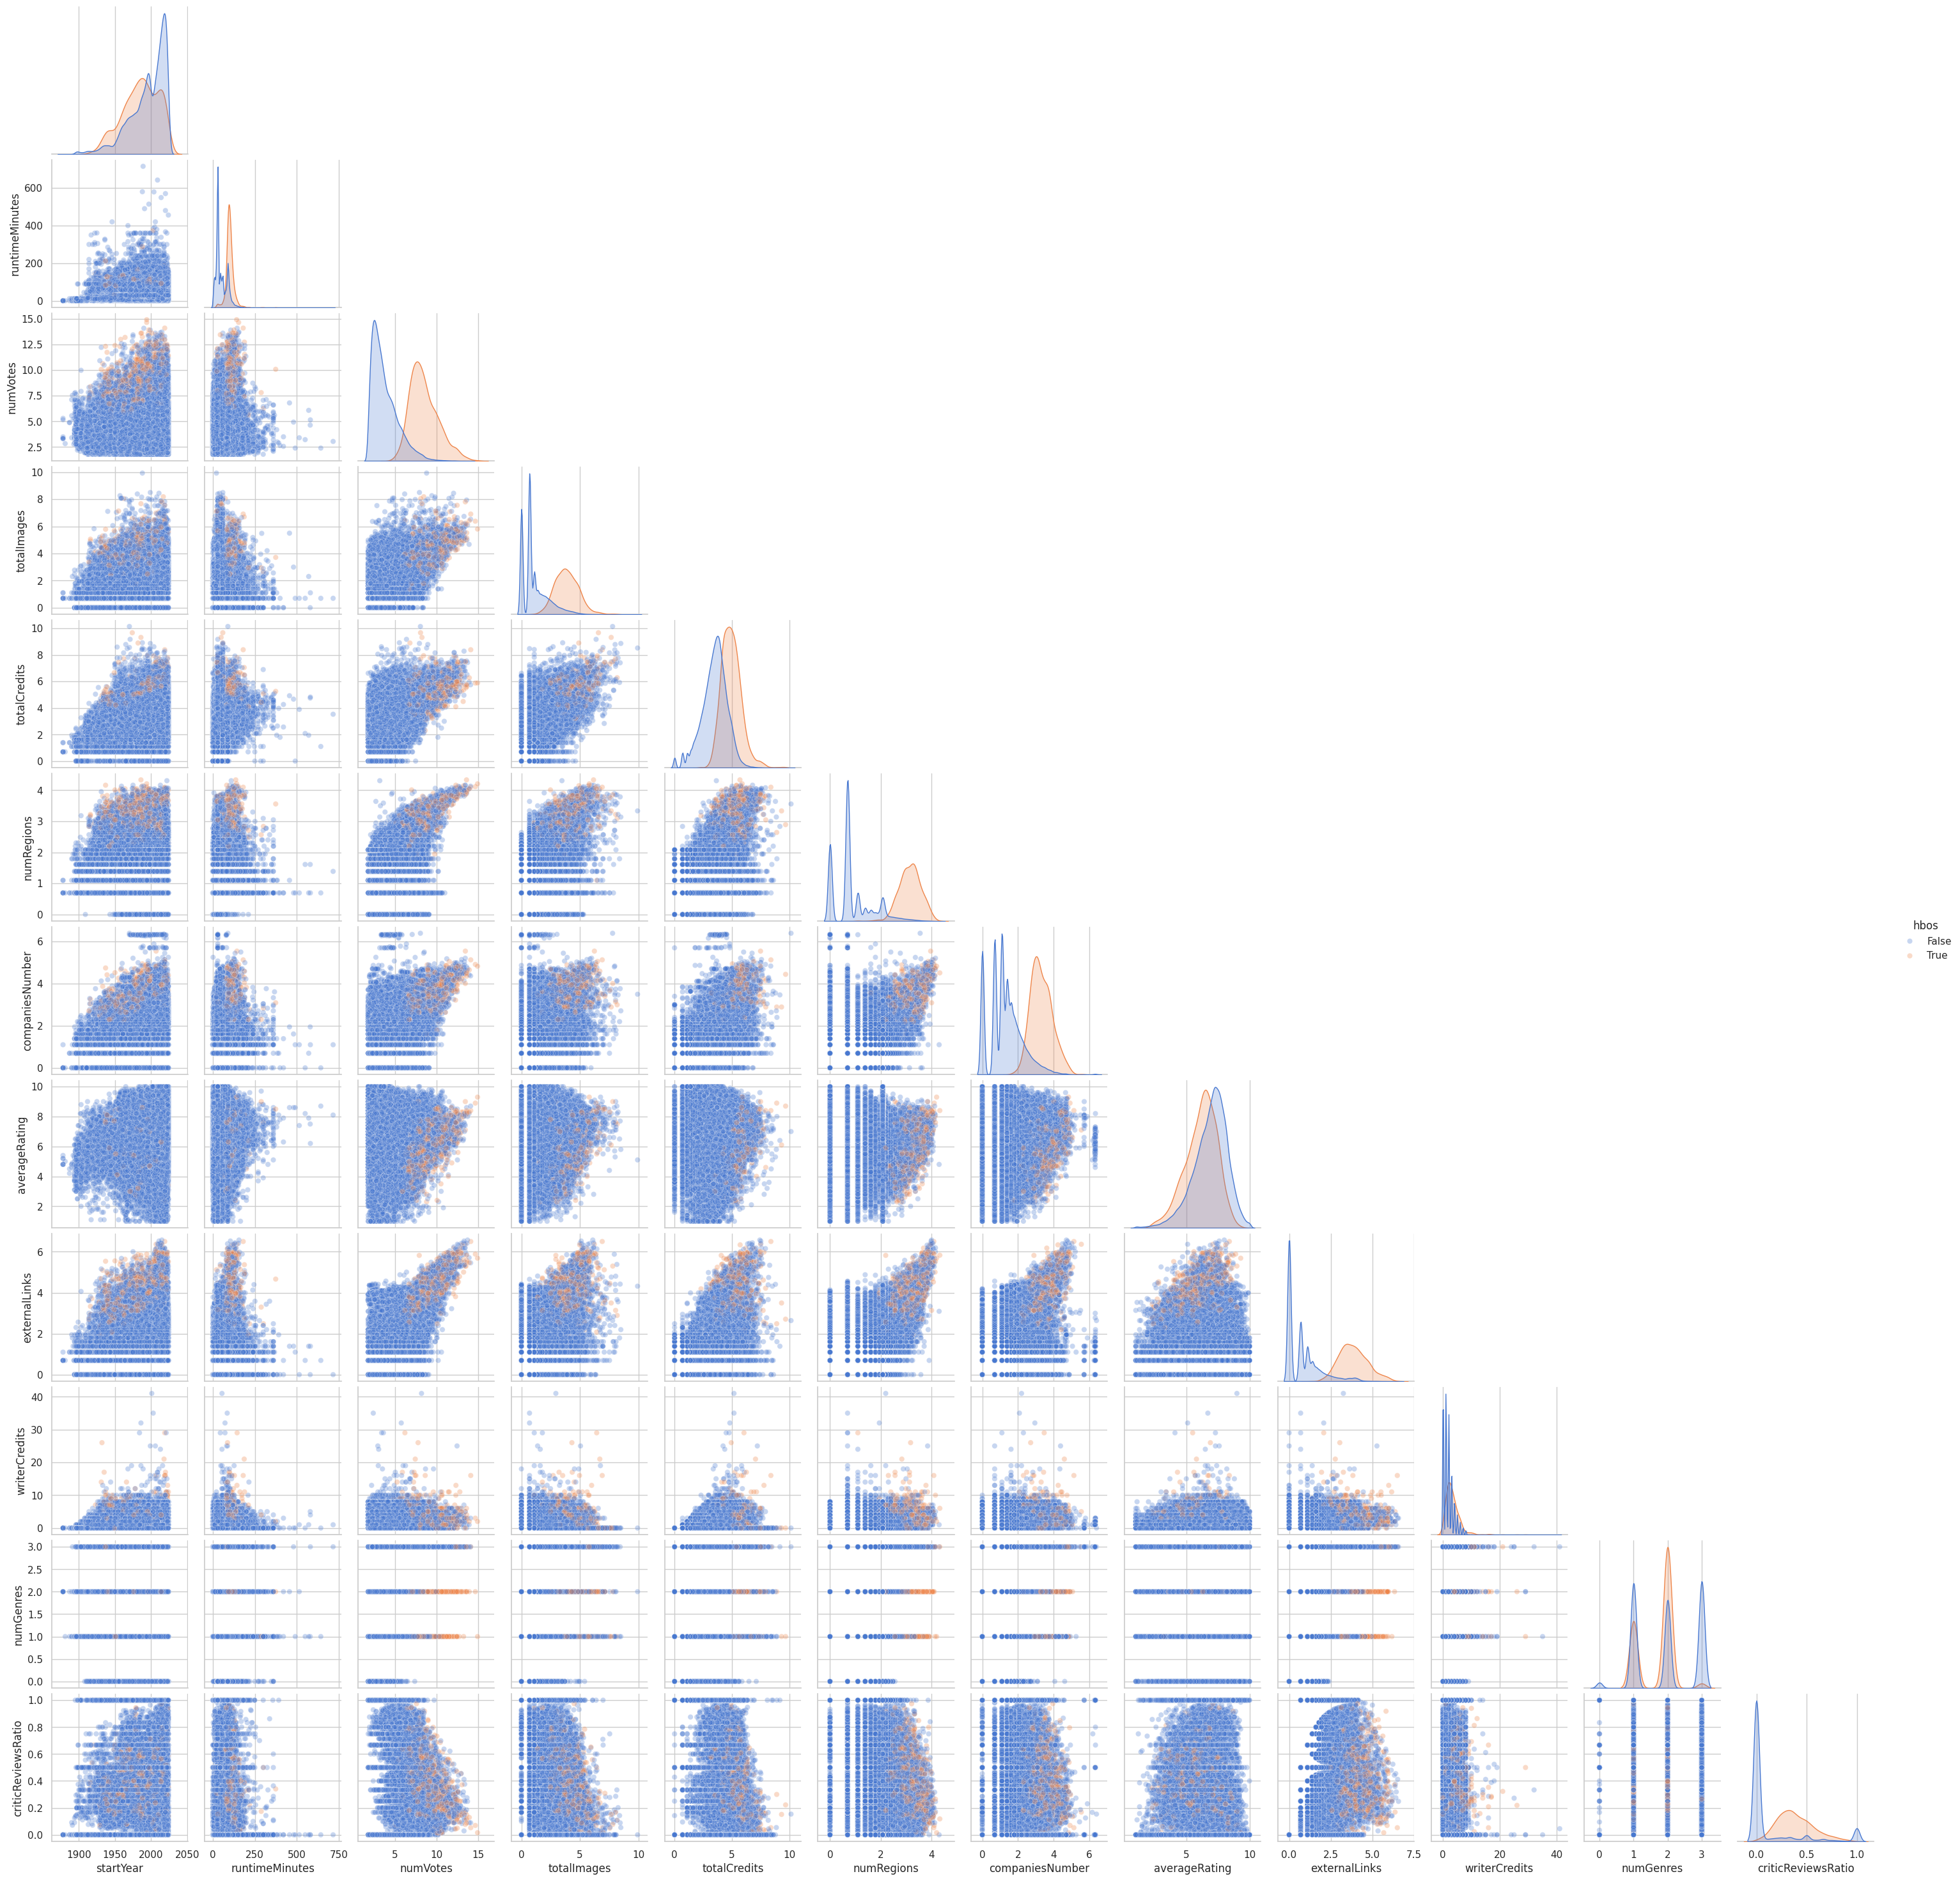

In [15]:
sns.pairplot(train, vars=num_cols, hue='hbos',
             diag_kind='kde', diag_kws=dict(common_norm=False),
             plot_kws=dict(alpha=.3), corner=True)

In [16]:
train[train['hbos']]['titleType'].value_counts()

titleType
movie           967
tvSeries         37
video            18
tvMovie          14
short             4
tvMiniSeries      4
tvSpecial         3
Name: count, dtype: int64

In [17]:
train[train['hbos']].sort_values('numVotes', ascending=False).head(20)

originalTitle   rating  startYear  \
89936                            The Shawshank Redemption  (9, 10]       1994   
76320                                        Pulp Fiction   (8, 9]       1994   
16857                                   Avengers: Endgame   (8, 9]       2019   
102029                                  Good Will Hunting   (8, 9]       1997   
100497                Le fabuleux destin d'Amélie Poulain   (8, 9]       2001   
59574                                   Full Metal Jacket   (8, 9]       1987   
95088                                              Aliens   (8, 9]       1986   
17791                                               Fargo   (8, 9]       1996   
8832                                         Transformers   (7, 8]       2007   
73573                                    Better Call Saul   (8, 9]       2015   
31768                                            Rain Man   (7, 8]       1988   
457     Dr. Strangelove or: How I Learned to Stop Worr...   (8, 9]       1964   
68326                                                Room   (8, 9]       2015   
58150                                             Vertigo   (8, 9]       1958   
80240                                       The Gentlemen   (7, 8]       2019   
55133                               Friends with Benefits   (6, 7]       2011   
37286                             Mission: Impossible III   (6, 7]       2006   
65228                                  The Simpsons Movie   (7, 8]       2007   
66545                                           Liar Liar   (6, 7]       1997   
54603                                            Magnolia   (7, 8]       1999   

        runtimeMinutes   numVotes  totalImages  totalCredits titleType  \
89936            142.0  14.896614     5.802118      5.883322     movie   
76320            154.0  14.632531     6.381816      5.874931     movie   
16857            181.0  14.079606     6.909753      8.383890     movie   
102029           126.0  13.906790     6.421622      6.270988     movie   
100497           122.0  13.597504     5.153292      5.758902     movie   
59574            116.0  13.596293     5.521461      5.602119     movie   
95088            137.0  13.574820     6.165418      5.690359     movie   
17791             98.0  13.510810     4.969813      5.517453     movie   
8832             144.0  13.435468     6.240276      7.482682     movie   
73573             45.0  13.430886     7.809541      7.487174  tvSeries   
31768            133.0  13.224896     4.919981      5.361292     movie   
457               95.0  13.172553     5.459586      4.488636     movie   
68326            118.0  13.034771     4.983607      5.707110     movie   
58150            128.0  12.982453     5.786897      5.278115     movie   
80240            113.0  12.939659     6.274762      6.541030     movie   
55133            109.0  12.900898     5.505332      6.302619     movie   
37286            126.0  12.888985     5.817111      7.340187     movie   
65228             87.0  12.775840     5.204007      6.904751     movie   
66545             86.0  12.735359     4.969813      6.093570     movie   
54603            188.0  12.714576     4.644391      6.489205     movie   

        canHaveEpisodes  numRegions  ... criticReviewsRatio hasAwards  \
89936             False    4.204693  ...           0.015694      True   
76320             False    4.110874  ...           0.069589      True   
16857             False    4.094345  ...           0.052585      True   
102029            False    4.043051  ...           0.128983      True   
100497            False    3.931826  ...           0.087125      True   
59574             False    3.988984  ...           0.147899      True   
95088             False    4.330733  ...           0.118063      True   
17791             False    3.891820  ...           0.110000      True   
8832              False    3.970292  ...           0.168729      True   
73573              True    3.850148  ...           0.0772

It looks like HBOS is identifying as outliers mainly movies, and very popular movies at that. In addition to that, a great majority of titles identified as outliers have received awards or nominations (a condition which is true only for a minority of the total records of the dataset).

### Visualization in latent space

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA()
pca_train = pca.fit_transform(train_X)

In [20]:
explained_variance = pca.explained_variance_ratio_

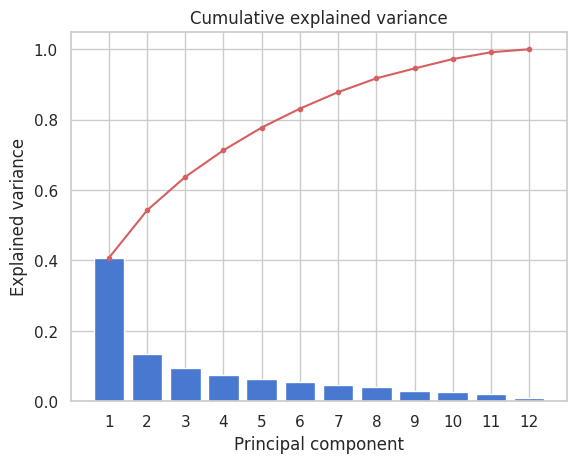

In [21]:
x = list(range(1, len(explained_variance) + 1))
plt.bar(x, height=explained_variance)
plt.xticks(x)
plt.plot(x, explained_variance.cumsum(), 'r.-')
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Cumulative explained variance")
plt.show()

In [22]:
pca_train = pd.DataFrame(pca_train)
pca_train['outlier'] = train['hbos']
pca_train['title'] = train['originalTitle'] + " " + train['startYear'].astype(str)

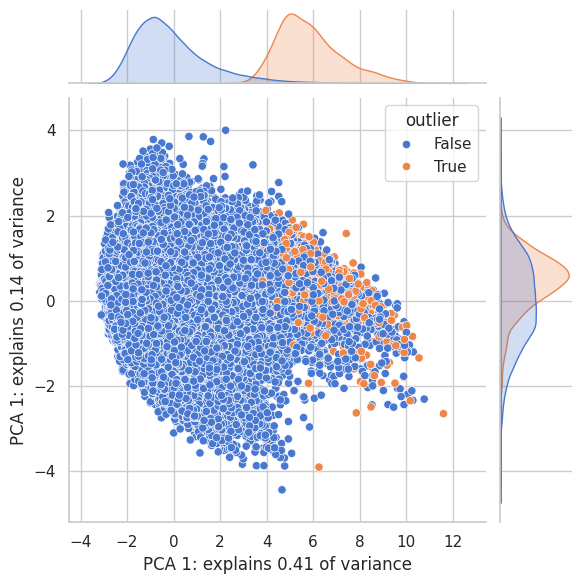

In [23]:
sns.jointplot(pca_train, x=0, y=1, hue='outlier',
              marginal_kws=dict(common_norm=False))
plt.xlabel(f"PCA 1: explains {round(explained_variance[0], 2)} of variance")
plt.ylabel(f"PCA 1: explains {round(explained_variance[1], 2)} of variance")
plt.show()

In [25]:
from sklearn.manifold import TSNE

In [26]:
tsne = TSNE(n_components=2)
tsne_train = tsne.fit_transform(train_X)

In [27]:
tsne_train = pd.DataFrame(tsne_train)
tsne_train['outlier'] = train['hbos']
tsne_train['title'] = train['originalTitle'] + train['startYear'].astype(str)

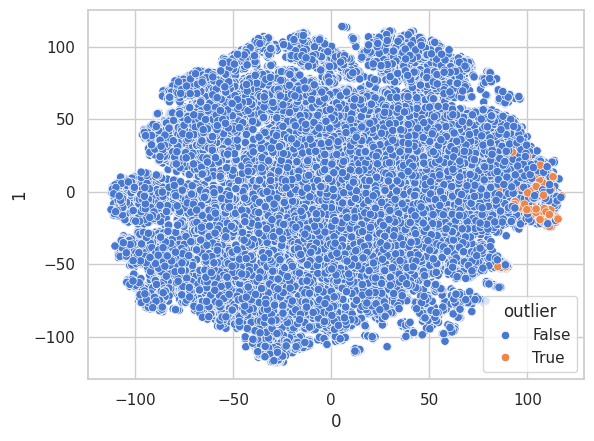

In [28]:
sns.scatterplot(tsne_train, x=0, y=1, hue='outlier')
plt.show()

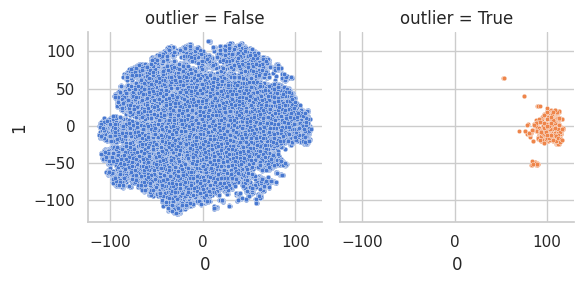

In [29]:
grid = sns.FacetGrid(tsne_train, col='outlier', hue='outlier')
grid.map_dataframe(sns.scatterplot, x=0, y=1, s=10)
plt.show()